In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
# following Chollet's example at https://nbviewer.jupyter.org/github/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb

In [3]:
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(244, 244, 3))
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 244, 244, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 250, 250, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 122, 122, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 122, 122, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

Step 1 - train new classifier with frozen base model

In [14]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Flatten, AveragePooling2D, Dropout

resnet = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
resnet.trainable = False
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [23]:
# following Adrian Rosebock's example @ https://www.pyimagesearch.com/2020/04/27/fine-tuning-resnet-with-keras-tensorflow-and-deep-learning/

class_model = resnet.output
class_model = AveragePooling2D(pool_size=(7, 7))(class_model)
class_model = Flatten(name="flatten")(class_model)
class_model = Dense(256, activation="relu")(class_model)
class_model = Dropout(0.5)(class_model)
class_model = Dense(10, activation="softmax")(class_model)

model = Model(inputs=resnet.input, outputs=class_model)
# from tensorflow.keras import Sequential
# model = Sequential()
# model.add(resnet)
# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dense(10, activation='softmax'))
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [6]:
from load_data import load_data_gen

data_gen_params = {
    "rotation_range": 40,
    "width_shift_range": 0.2,
    "height_shift_range": 0.2,
    "shear_range": 0.2,
    "zoom_range": 0.2,
    "horizontal_flip": True,
}
(train_data, val_data, test_data) = load_data_gen(task=2, img_dims=244, **data_gen_params)

Found 11209 images belonging to 10 classes.
Found 1245 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from utils import data_fldr

train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.1)
train_data = train_datagen.flow_from_directory(
    f"{data_fldr}/imagewoof-320/train",
    batch_size=32,
    shuffle=True,
    subset="training",
    target_size=(244, 244),
    class_mode='categorical')
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.1)
val_data = test_datagen.flow_from_directory(
    f"{data_fldr}/imagewoof-320/train",
    batch_size=32,
    target_size=(244, 244),
    shuffle=True,
    subset="validation",
    class_mode='categorical')

Found 11209 images belonging to 10 classes.
Found 1245 images belonging to 10 classes.


In [11]:
for image_batch, labels_batch in train_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  print(labels_batch[1])
  break

(32, 244, 244, 3)
(32, 10)
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [25]:
opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=30,
)

Epoch 1/30
351/351 [==============================] - 79s 219ms/step - loss: 0.6464 - accuracy: 0.7981 - val_loss: 0.1803 - val_accuracy: 0.9430

Found 500 images belonging to 10 classes.
39/39 [==============================] - 7s 180ms/step - loss: 0.2789 - accuracy: 0.9446

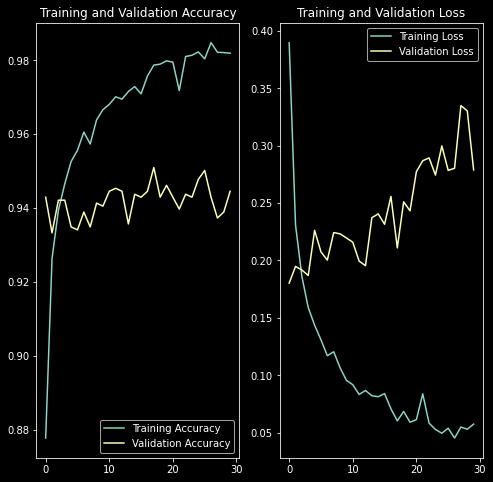

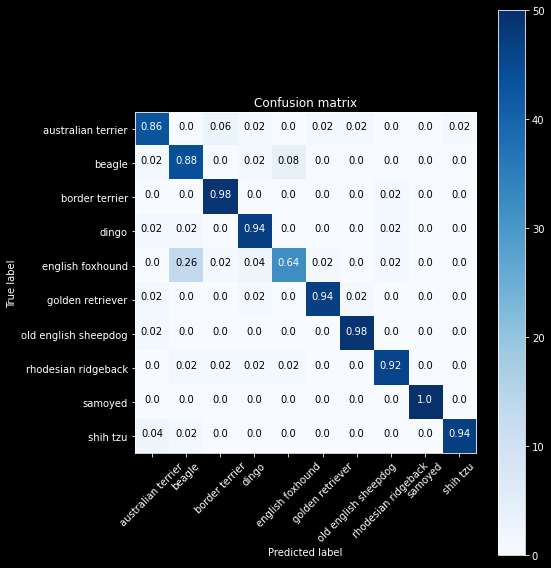

In [27]:
from sklearn.metrics import confusion_matrix, classification_report
from vgglite_1.model import plot_training, plot_confusion_matrix

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_data = test_datagen.flow_from_directory(
    f"{data_fldr}/imagewoof-320/val",
    batch_size=32,
    target_size=(244, 244),
    shuffle=False,
    class_mode='categorical')

val_result = model.evaluate(val_data)
print(f"Final validation results: {dict(zip(model.metrics_names, val_result))}")
result = model.evaluate(test_data)
print(f"Final test results: {dict(zip(model.metrics_names, result))}")
plot_training(history)
# print(f"FLOPS: {get_flops(model)}")
Y_pred = model.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_data.classes, y_pred)
print(classification_report(test_data.classes, y_pred, target_names=test_data.class_indices.keys()))
plot_confusion_matrix(cm, test_data.class_indices.keys())

as expected the model's performance is hampered by the under-represented class english foxhound which is being confused
for the similar class beagle. Fine-tuning may improve the accuracy slightly (potentially) but to see any significant
boost to performance the model should be weighted or the under-represented class should be oversampled

In [30]:
# save initial model trained on imbalanced dataset
model.save("../saved_models/initial_imbalanced.h5")

Step 2 - unfreeze res5c block and retrain final layers and added classifier

In [17]:
resnet.trainable = True

res5c = 0
trainable_layer_count = 0
for layer in resnet.layers:
    if layer.name[0:5] == "conv5":
        res5c = 1
    if not res5c:
        layer.trainable = False
    if layer.trainable:
        trainable_layer_count += 1
        print(layer.name)

print(f"{trainable_layer_count} trainable layers")
resnet.summary()

conv5_block1_1_conv
conv5_block1_1_bn
conv5_block1_1_relu
conv5_block1_2_conv
conv5_block1_2_bn
conv5_block1_2_relu
conv5_block1_0_conv
conv5_block1_3_conv
conv5_block1_0_bn
conv5_block1_3_bn
conv5_block1_add
conv5_block1_out
conv5_block2_1_conv
conv5_block2_1_bn
conv5_block2_1_relu
conv5_block2_2_conv
conv5_block2_2_bn
conv5_block2_2_relu
conv5_block2_3_conv
conv5_block2_3_bn
conv5_block2_add
conv5_block2_out
conv5_block3_1_conv
conv5_block3_1_bn
conv5_block3_1_relu
conv5_block3_2_conv
conv5_block3_2_bn
conv5_block3_2_relu
conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out
32 trainable layers
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 3)]  0                                            
_______________________________________________________________

manually finding images "in the wild" (from Pinterest image sources)


In [ ]:
dog_img_urls = {
    "shih tzu": [
        "https://i.pinimg.com/474x/2c/63/70/2c63706dc8a38fac474b54fcf490e64a.jpg",
        "https://i.pinimg.com/474x/9c/5c/4c/9c5c4c97992c05622a9d373a9dd64981--shih-tzus-shih-tzu-puppy.jpg",
        "https://i.pinimg.com/474x/f0/2d/6b/f02d6bf6ae06c3de104c7f3e28f1d9ac.jpg",
        "https://i.pinimg.com/474x/20/ee/dc/20eedcb23f3a30adc78d0ccfb3ba2402--animal-pics-sweet.jpg",
        "https://i.pinimg.com/474x/de/4d/08/de4d08e8c8146a001265d2b34869be5a.jpg"
    ],
    "samoyed": [
        "https://i.pinimg.com/474x/92/71/03/927103cb769ffa4dc16c8a4c91d3c76e.jpg",
        "https://i.pinimg.com/474x/d0/64/f8/d064f8db12669c1c366563f9bbbb95d9.jpg",
        "https://i.pinimg.com/474x/5b/47/95/5b47957bc2d6dd3645e349d5a25ce135.jpg",
        "https://i.pinimg.com/474x/d2/35/3d/d2353d4d367202f8f33e896d430d0267.jpg",
        "https://i.pinimg.com/474x/1d/2f/fd/1d2ffd8f5131897b39cba1ddc541ff71.jpg",
    ],
    "rhodesian ridgeback": [
        "https://i.pinimg.com/474x/2c/36/cd/2c36cd56a8aa170ad52fc8f349cadc69.jpg",
        "https://i.pinimg.com/474x/cb/43/40/cb43402aad8a80a5631214e0dfa7273d.jpg",
        "https://i.pinimg.com/474x/7e/2e/5a/7e2e5a4eee78a8e1d740eaf3f45ef1e2.jpg",
        "https://i.pinimg.com/474x/8f/9f/b4/8f9fb4b7061d657c1b9c236c87482ada.jpg",
        "https://i.pinimg.com/474x/5d/cd/4c/5dcd4c108bffa5fcbed2527983a3a73a--rodesian-ridgeback-isa.jpg",
    ],
    "old english sheepdog": [
        "https://i.pinimg.com/474x/6a/5c/d6/6a5cd6ebbb939ff4e77a474f5080b047.jpg",
        "https://i.pinimg.com/474x/6d/cd/c1/6dcdc144bfa9e308635c8d3637a6d5ac.jpg",
        "https://i.pinimg.com/474x/cd/0d/06/cd0d068a27396f4a4d7a597531576dac.jpg",
        "https://i.pinimg.com/474x/66/4d/50/664d5015d83fbcc25b6b0b681e9bb34e.jpg",
        "https://i.pinimg.com/474x/52/be/0d/52be0d13a3a87281b2b971687ec273c3.jpg",
    ],
    "golden retriever": [
        "https://i.pinimg.com/474x/ba/63/75/ba63752f89f2707c76a96677c228754b.jpg",
        "https://i.pinimg.com/474x/3a/53/0f/3a530f1b2f22093b59012f7a47f6e6a4.jpg",
        "https://i.pinimg.com/474x/40/b6/c6/40b6c6fbe45d8284118a541c229e28df.jpg",
        "https://i.pinimg.com/474x/59/de/de/59dede67a5e089267b077e72be7b6903.jpg",
        "https://i.pinimg.com/474x/e5/3c/a0/e53ca0dc2ed6e29a8c66daa6213770a1.jpg",
    ],
    "english foxhound": [
        "https://i.pinimg.com/474x/91/16/8f/91168fa691c87f3ed7ccf18bc33e6c14.jpg",
        "https://i.pinimg.com/474x/12/6a/b5/126ab5b5a90f1608c29ac0f8d788a125.jpg",
        "https://i.pinimg.com/474x/5c/1e/79/5c1e79261214a3f9965e183f59d37e58.jpg",
        "https://i.pinimg.com/474x/ff/01/61/ff0161ab7a4638338416d8ff424bb2e3.jpg",
        "https://i.pinimg.com/474x/8d/02/35/8d02351a3db0920907c4ed1d583f151c.jpg",
    ],
    "dingo": [
        "https://i.pinimg.com/474x/21/33/42/21334265e2135acf693c18a82dbe67f5.jpg",
        "https://i.pinimg.com/474x/e4/b9/8b/e4b98b262685e47cce3d429990a909a3.jpg",
        "https://i.pinimg.com/474x/e9/3d/e2/e93de29f36037732c3fbfedbbef4ee18.jpg",
        "https://i.pinimg.com/474x/47/74/d1/4774d126ca26eea15342698cb82c50a7.jpg",
        "https://i.pinimg.com/474x/dd/dc/04/dddc04b8888adc55a9e5f78bdde50952--australian-animals-wild-dogs.jpg",
    ],
    "border terrier": [
        "https://i.pinimg.com/474x/46/51/9b/46519b9ac283dca49b2c3cd7bacb0409.jpg",
        "https://i.pinimg.com/474x/2b/3e/06/2b3e06094e0e2bbbca46d82fb87ffc29.jpg",
        "https://i.pinimg.com/474x/ba/35/95/ba3595447afeb3c53e6cc824903b4ae0.jpg",
        "https://i.pinimg.com/474x/8e/a8/9a/8ea89ab59164e3f2beea88028942cedf.jpg",
        "https://i.pinimg.com/474x/47/89/38/478938357602dd81dc8fd8d85a8a0d5e.jpg",
    ],
    "beagle": [
        "https://i.pinimg.com/474x/a7/52/5e/a7525e7370d4401a1862b48b044d0047.jpg",
        "https://i.pinimg.com/474x/0e/23/8c/0e238cad026054885fa0f9a3d67920be.jpg",
        "https://i.pinimg.com/474x/29/c8/b2/29c8b25370ebb078c6badd41612957b0.jpg",
        "https://i.pinimg.com/474x/2b/fc/ef/2bfcefb172f6a0d32a5aa93ae9922518.jpg",
        "https://i.pinimg.com/474x/53/be/97/53be97011b5247dfd8f0bfd239fd55bf.jpg",
    ],
    "australian terrier": [
        "https://i.pinimg.com/474x/f6/8d/e7/f68de7acecd75e5a20dd0fc810c9c458.jpg",
        "https://i.pinimg.com/474x/c5/5c/3f/c55c3f025e5266ef543b378ea4e0791e.jpg",
        "https://i.pinimg.com/474x/94/87/ea/9487ea41f05fc155f7c5c22529d45c10.jpg",
        "https://i.pinimg.com/474x/10/70/22/10702208b21795153d4f8c7cedf6c9fd.jpg",
        "https://i.pinimg.com/474x/b4/f7/85/b4f785bfe18fe182c6ebfc7040d3d614--silky-terrier-terrier-mix.jpg",
    ],
}

In [ ]:
# adapted from Paul Whelan's course notes
def smoothing(data, f=0.8):
    smoothed = []
    for d in data:
        smoothed_point = (smoothed[-1] * f + d * (1 - f)) if smoothed else d
        smoothed.append(smoothed_point)
    return smoothed